In [1]:
import sys

import pint 
import csv
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statistics import mean
#squared default=True, If True returns MSE value, if False returns RMSE value.
#mean_squared_error(y_true, y_pred, squared=False)) # RMSE

# Set the project path here
PathProj = "C:\\Users\\tepang\\Desktop\\Test3"
sys.path.append(PathProj)

# IMPORTS
# ----------------------------------------------------- Project modules
from genDispatch import *
from ToWRF import *
import gd_core as __core
import PowerPlants as pp
import NEMS as mkt

from hyperopt.pyll import scope
from collections import OrderedDict
from random import seed, random, randint
from hyperopt import fmin, tpe, hp, Trials



# Functions

def calibration_list():
    List=[]
    number=len(PPdb['params'])
    for counter in range (number):
        name='Eff '+ str(counter)
        List.append(name)

    List1=[]
    number=len(PPdb['params'])
    for counter in range (number):
        name='MTTR '+ str(counter)
        List1.append(name)

    List2=[]
    number=len(PPdb['params'])
    for counter in range (number):
        name='AF '+ str(counter)
        List2.append(name) 
    
    return List,List1,List2

def norm(original, params):
    if params.max()-params.min() == 0: return 0
    else:
        norm = (original - params.min())/(params.max()-params.min())
        return norm
    
def standard(original, params):
    if params.std() == 0: return 0
    else:
        standard = (original - params.mean())/(params.std())
        return standard

def loss_LNG(Results):
    global LNG_IMPORT
    Fuel_Mix_in=calc_fuelmix(Results, ppclasses='by fuel', timeby='year', mixby='input', units='ktoe', cogen_alloc=None, percent_byrow=True)
    
    E_lng = Fuel_Mix_in['LNG'] # E_lng = LNG consumed (from model, 2012.08 (in report))
    #import_lng = 2261.9        # Whole yr (2016) value (in ktoe) from SES 
    import_lng = LNG_IMPORT
    if 0.9*import_lng - E_lng > 0:
        loss = 0.9*import_lng - E_lng 
    else: 
        loss= 0
    return loss

def loss_cogen(Results):
    global Q_COGEN_UB
    # Q_cogen_ub (ktoe) from Sankey Estimate, 2235 (report)
    # Q_cogen (ktoe) from model 1913 (2016) 
    # Q_cogen_ub = 2235         #to get from Sankey Estimate
    
    Q_cogen_ub = Q_COGEN_UB
    
    calc_allheat(Results)
    Q_cogen = Results['Total cogen heat [ktoe]']
        
    if Q_cogen > Q_cogen_ub:
        loss = Q_cogen - Q_cogen_ub
    else:
        loss = 0
    return loss

def Company_total_generation(Results):
    unique_companies= PPdb['master']['Owner/Operator'].drop_duplicates()
    companies=tuple(unique_companies)
    
    keys = companies
    company = dict.fromkeys(companies,())
    
    # Getting the Generating Units of each Company
    for index in PPdb['master'].index:
        index_c=0
        for c in companies:
            if PPdb['master']['Owner/Operator'][index] ==  companies[index_c]:                #'Senoko Energy Pte Ltd'
                name=companies[index_c]
                company[name]=company[name]+(index,)
            index_c = index_c + 1    
    company
    
    # Getting the half-hourly dispatch of each Company
    Results['Company']={}
    for c in range(len(companies)):
        Results['Company'][companies[c]]=Results['dispatch [MW]'].iloc[:,list(company[companies[c]])]

    # Getting the total generation [MWh] of each Company
    Results['Company Total [MWh]']={}
    for c in range(len(companies)):
        Results['Company Total [MWh]'][companies[c]]=0.5*Results['Company'][companies[c]].sum(axis=0).sum()
    Results['Company Total [MWh]']
    
    # Getting the MWh generation of each company 
    Ser1=pd.Series(Results['Company Total [MWh]'], index=companies)
    Ser1
    
    # Getting the percentage generation share of each company 
    Total_MWh=Ser1.sum()
    Ser2=(Ser1/Ser1.sum())*100
    Ser2
    
    df2=pd.DataFrame({"Total GWh":Ser1/1000, "Percentage": Ser2})
    return df2

def Company_total_generation1(Results):
    Ser_gencos=PPdb['master']['Owner/Operator']
    
    unique_companies= PPdb['master']['Owner/Operator'].drop_duplicates()
    companies=tuple(unique_companies)
    
    # Getting the Generating Units of each Company
    company = {genco: (Ser_gencos.loc[Ser_gencos == genco]).index for genco in Ser_gencos.unique()}
   
    # Getting the half-hourly dispatch of each Company
    Results['Company']={}
    for c in range(len(companies)):
        Results['Company'][companies[c]]=Results['dispatch [MW]'].iloc[:,list(company[companies[c]])]

    # Getting the total generation [MWh] of each Company
    Results['Company Total [MWh]']={}
    for c in range(len(companies)):
        Results['Company Total [MWh]'][companies[c]]=0.5*Results['Company'][companies[c]].sum(axis=0).sum()
    Results['Company Total [MWh]']
    
    # Getting the MWh generation of each company 
    Ser1=pd.Series(Results['Company Total [MWh]'], index=companies)
    Ser1
    
    # Getting the percentage generation share of each company 
    Total_MWh=Ser1.sum()
    Ser2=(Ser1/Ser1.sum())*100
    Ser2
    
    df2=pd.DataFrame({"Total GWh":Ser1/1000, "Percentage": Ser2})
    return df2

def cal_op_fuel_mix(Results):
    # Getting Fuel Mix o/p of the model
    Fuel_Mix=calc_fuelmix(Results, ppclasses='by fuel type 2', timeby='month', mixby='output', units='ktoe', cogen_alloc=None, percent_byrow=True)
    #Fuel_Mix=calc_fuelmix(Results, ppclasses='by fuel', timeby='month', mixby='output', units='ktoe', cogen_alloc=None, percent_byrow=True)
    #Fuel_Mix=calc_fuelmix_test(Results, ppclasses='by fuel', timeby='month', mixby='output', units='ktoe', cogen_alloc=None, percent_byrow=True)

    #Fuel_Mix['Natural Gas']=Fuel_Mix['PNG']+Fuel_Mix['LNG']
    Fuel_Mix['Petroleum Products']=Fuel_Mix['Oil']
    #Fuel_Mix['Others']=Fuel_Mix['Waste']
    return Fuel_Mix

def cal_ip_fuel_mix(Results, FM_in_pub):
    '''
    calc_fuelmix(Results, ppclasses='by fuel', timeby='month', mixby='input', units='ktoe', cogen_alloc=None, percent_byrow=True)

    Annual_in_model={}
    Annual_in_model['Natural Gas']=Results['input mix [ktoe]', 'by fuel', 'month'].iloc[:,0:2].sum().sum()
    Annual_in_model['Others']=Results['input mix [ktoe]', 'by fuel', 'month'].iloc[:,2:3].values.sum()
    Annual_in_model['Coal']=Results['input mix [ktoe]', 'by fuel', 'month'].iloc[:,3:4].values.sum()
    Annual_in_model['Oil']=Results['input mix [ktoe]', 'by fuel', 'month'].iloc[:,4:5].values.sum()
 
    model=[Annual_in_model['Natural Gas'],Annual_in_model['Oil'],Annual_in_model['Coal'],Annual_in_model['Others']]
    model
    '''
    Annual_in_model1={}
    Annual_out_model1=calc_fuelmix(Results, ppclasses='by fuel type 2', timeby='month', mixby='input', units='ktoe', cogen_alloc=None, percent_byrow=True).sum()
    Annual_out_model1
  
    index=['Natural Gas','Oil','Coal','Others']
    EMA = FM_in_pub
    # EMA=[8364.23,122.80,259.22,788.60] # Data for 2016
    # EMA20=[5011.5, 43.0, 138.5,366.8] # Data for 2020 until July

    Annual_in=pd.DataFrame(None,index=index)
    Annual_in['Model']=pd.DataFrame(Annual_out_model1, index=index)
    Annual_in['EMA']=pd.DataFrame(EMA, index=index)
    Annual_in['Error']=Annual_in['Model']-Annual_in['EMA']
    return Annual_in

def cal_RMSE_fuel(Results, FM_out_pub, FM_out_cal, FM_in_pub):    
    RMSE_NG_out = mean_squared_error(FM_out_pub['Natural Gas'], FM_out_cal['Natural Gas'], squared=False) # RMSE
    #print('RMSE_Oil_out',FM_out_pub['Petroleum Products'],FM_out_cal['Oil'])
    RMSE_Oil_out = mean_squared_error(FM_out_pub['Petroleum Products'], FM_out_cal['Oil'], squared=False) # RMSE
    RMSE_Coal_out = mean_squared_error(FM_out_pub['Coal'], FM_out_cal['Coal'], squared=False) # RMSE
    #RMSE_Others_out = mean_squared_error(FM_out_pub['Others'], FM_out_cal['Waste'], squared=False) # RMSE
    RMSE_Others_out = mean_squared_error(FM_out_pub['Others'], FM_out_cal['Others'], squared=False) # RMSE
    
    #Published_data = [8364.23,122.80,259.22,788.60] # Data for 2016
    Annual_in = cal_ip_fuel_mix(Results, FM_in_pub)

    RMSE_in = mean_squared_error(Annual_in['Model'], Annual_in['EMA'], squared=False)
    
    return RMSE_in, RMSE_NG_out, RMSE_Oil_out, RMSE_Coal_out, RMSE_Others_out

def calc_score(dynamic_params):
    global RUN, RESULTS_DF, RESULTS_DF0, RESULTS_DF1, RESULTS_DF2, RESULTS_GEN_SHARE, MTTF_USED, AF_USED, RANDSEEDS, RAN, \
    RANDSEEDS_DFS, PARAMS_DFS, OUT_FILE, PERIOD_FROM, PERIOD_TO, FUEL_MIX_IN_PUBLIC, FUEL_MIX_OUT_PUBLIC, SCORE_WEIGHTS,\
    PRE_CALIBRATE_PARAMS

    List, List1, List2 = calibration_list()
            
    count = 0    
    for unit in List:
        #print(unit)   # Checking the order of the List 
        PPdb['params']['Full Load Efficiency [%]'].iloc[count] = dynamic_params[unit]
        count = count + 1
    
    count = 0    
    for unit in List1:
        #print(unit)   # Checking the order of the List 
        if PPdb['params']['Technology'][count]=='Oil-fired ST':
            #print(unit,'ST MTTF')
            PPdb['params']['Mean Time to Repair [wks]'].iloc[count] = 53
        else:
            PPdb['params']['Mean Time to Repair [wks]'].iloc[count] = dynamic_params[unit]
        count = count + 1
        
    count = 0    
    for unit in List2:
        #print(unit)   # Checking the order of the List
        if PPdb['params']['Technology'][count]=='Oil-fired ST':
            #print(unit,'ST AF')
            PPdb['params']['Average Failures per year [yr-1]'].iloc[count]= 0.98
        else:
            PPdb['params']['Average Failures per year [yr-1]'].iloc[count] = dynamic_params[unit]
        count = count + 1
     
    for count in range(len(PPdb['params'])):
        PPdb['randseeds']['Full Load Efficiency'][count] = randint(86400,int(round(time.time())))
        PPdb['randseeds']['Start Online'][count] = randint(86400,int(round(time.time()))) 
        PPdb['randseeds']['UP Time Duration'][count] = randint(86400,int(round(time.time())))
        PPdb['randseeds']['DOWN Time Duration'][count] = randint(86400,int(round(time.time())))
        RAN['Gen '+ str(count) + ' n_e_FL'][RUN] = PPdb['randseeds']['Full Load Efficiency'][count]
        RAN['Gen '+ str(count) + ' start_OL'][RUN] = PPdb['randseeds']['Start Online'][count]
        RAN['Gen '+ str(count) + ' UP'][RUN] = PPdb['randseeds']['UP Time Duration'][count]
        RAN['Gen '+ str(count) + ' DOWN'][RUN] = PPdb['randseeds']['DOWN Time Duration'][count]
    
    RANDSEEDS_DFS[RUN] = PPdb['randseeds'].copy()
    PARAMS_DFS[RUN] = PPdb['params'].copy()
    
    #print(PPdb['params'])
    #print(PPdb['randseeds'])
    #print(RANDSEEDS_DFS)
    
    __core.reinit_fleet()  

    #set_period(t_from='2016 Apr 01', t_to='2016 Apr 30')
    set_period(t_from=PERIOD_FROM, t_to=PERIOD_TO)
    set_scenario({'sys demand': 'Baseline'})

    Results = solve(simulation_name='Baseline', runchecks=False, daily_progress=False)
       
    Fuel_Mix = cal_op_fuel_mix(Results)
    
    df = FUEL_MIX_OUT_PUBLIC
    Weights = SCORE_WEIGHTS
    RMSE_params = PRE_CALIBRATE_PARAMS
    
    # Published_data = [8364.23,122.80,259.22,788.60] # Data for 2016
    Published_data = FUEL_MIX_IN_PUBLIC
    RMSE_in, RMSE_NG_out, RMSE_Oil_out, RMSE_Coal_out, RMSE_Others_out = cal_RMSE_fuel(Results, df, Fuel_Mix,Published_data)
    Annual_in=cal_ip_fuel_mix(Results, Published_data)
    
    RMSE_out = (Weights.iloc[0]['NG']*RMSE_NG_out + Weights.iloc[0]['Oil']*RMSE_Oil_out 
                + Weights.iloc[0]['Coal']*RMSE_Coal_out + Weights.iloc[0]['Others']*RMSE_Others_out)
    
    # Std_RMSE
    Std_RMSE_NG_out = standard(RMSE_NG_out, RMSE_params['RMSE NG out'])
    Std_RMSE_Oil_out = standard(RMSE_Oil_out, RMSE_params['RMSE Oil out'])
    Std_RMSE_Coal_out = standard(RMSE_Coal_out, RMSE_params['RMSE Coal out'])
    Std_RMSE_Others_out = standard(RMSE_Others_out, RMSE_params['RMSE Others out'])
    Std_RMSE_in  = standard(RMSE_in, RMSE_params['RMSE in'])
    Std_loss_LNG = standard(loss_LNG(Results),RMSE_params['Loss LNG'])
    Std_loss_cogen = standard(loss_cogen(Results),RMSE_params['Loss Cogen'])
   
    Std_RMSE_out_wt = (Weights.iloc[0]['NG']*Std_RMSE_NG_out + Weights.iloc[0]['Oil']*Std_RMSE_Oil_out 
                        + Weights.iloc[0]['Coal']*Std_RMSE_Coal_out + Weights.iloc[0]['Others']*Std_RMSE_Others_out)
         
    score        =  (Weights.iloc[0]['RMSE out']*RMSE_out + Weights.iloc[0]['RMSE in']*RMSE_in 
                     + Weights.iloc[0]['Loss LNG']*loss_LNG(Results) + Weights.iloc[0]['Loss Cogen']*loss_cogen(Results))
    score_std     =  (Weights.iloc[0]['RMSE out']*Std_RMSE_out_wt + Weights.iloc[0]['RMSE in']*Std_RMSE_in 
                      + Weights.iloc[0]['Loss LNG']*Std_loss_LNG + Weights.iloc[0]['Loss Cogen']*Std_loss_cogen)
  
    
    RESULTS_GEN_SHARE.loc[RUN]=Company_total_generation1(Results)['Percentage'].values  
    RESULTS_DF.loc[RUN]=[RUN+1,score, RMSE_NG_out, RMSE_Oil_out, RMSE_Coal_out,RMSE_Others_out,RMSE_out,
                         RMSE_in,loss_LNG(Results),loss_cogen(Results)]
    RESULTS_DF0.loc[RUN]=[score_std, Std_RMSE_NG_out, Std_RMSE_Oil_out, Std_RMSE_Coal_out,Std_RMSE_Others_out,
                          Std_RMSE_out_wt, Std_RMSE_in, Std_loss_LNG, Std_loss_cogen]
    '''
    RESULTS_DF1.loc[RUN]=[score_maxmin, NRMSE_NG_out_maxmin, NRMSE_Oil_out_maxmin, NRMSE_Coal_out_maxmin,
                          NRMSE_Others_out_maxmin, NRMSE_out_maxmin, NRMSE_in_maxmin,
                          score_mean,   NRMSE_NG_out_mean  , NRMSE_Oil_out_mean,   NRMSE_Coal_out_mean,   
                          NRMSE_Others_out_mean, NRMSE_out_mean, NRMSE_in_mean]
    RESULTS_DF2.loc[RUN]=[score_norm, score_norm_wt, score_norm1, score_norm_wt1, 
                          Norm_RMSE_NG_out, Norm_RMSE_Oil_out, Norm_RMSE_Coal_out, Norm_RMSE_Others_out, 
                          Norm_RMSE_out, Norm_RMSE_out_wt, Norm_RMSE_in, Norm_loss_LNG,Norm_loss_cogen]
    '''
    MTTF_USED.loc[RUN]=PPdb['params']['Mean Time to Repair [wks]'].values
    AF_USED.loc[RUN]=PPdb['params']['Average Failures per year [yr-1]'].values
    RANDSEEDS = pd.DataFrame.from_dict(RAN)
    
    loss = score_std
    
    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow(RESULTS_DF.loc[RUN].values.tolist() + RESULTS_DF0.loc[RUN].values.tolist() 
                    + RANDSEEDS.loc[RUN].values.tolist()
                    + RESULTS_GEN_SHARE.loc[RUN].values.tolist()
                    + MTTF_USED.loc[RUN].values.tolist() + AF_USED.loc[RUN].values.tolist() + [loss]
                    + PPdb['params']['Full Load Efficiency [%]'].values.tolist()
                    + MTTF_USED.loc[RUN].values.tolist() + AF_USED.loc[RUN].values.tolist()
                    ) 
    # MTTF & AF repeated to use as a check
    of_connection.close()
    
    RUN=RUN+1 
    
    #print(Fuel_Mix)
    print("NG     RMSE (out) std     = {0:.2f} {1:.2f} ".format(RMSE_NG_out, Std_RMSE_NG_out)) 
    print("Oil    RMSE (out) std     = {0:.2f} {1:.2f} ".format(RMSE_Oil_out, Std_RMSE_Oil_out)) 
    print("Coal   RMSE (out) std     = {0:.2f} {1:.2f} ".format(RMSE_Coal_out, Std_RMSE_Coal_out))
    print("Others RMSE (out) std     = {0:.2f} {1:.2f} ".format(RMSE_Others_out, Std_RMSE_Others_out))
    print("       RMSE (out) std     = {0:.2f} {1:.2f} ".format(RMSE_out, Std_RMSE_out_wt))
    print("       RMSE  (in) std     = {0:.2f} {1:.2f} ".format(RMSE_in,Std_RMSE_in)) 
    print("       Loss LNG   std     = {0:.2f} {1:.2f} ".format(loss_LNG(Results), Std_loss_LNG))
    print("       Loss Cogen std     = {0:.2f} {1:.2f} ".format(loss_cogen(Results), Std_loss_cogen))
    
    print("SCORE             std     = {0:.2f} ".format(score_std )) 
    #print(Company_total_generation(Results))
    print(Company_total_generation1(Results))

    return loss 

def calc_score_studies(dynamic_params):
    #To use with prepare_save_file_studies(outfile)
    global RUN, RESULTS_DF, RESULTS_DF0, RESULTS_DF1, RESULTS_DF2, RESULTS_GEN_SHARE, MTTF_USED, AF_USED, RANDSEEDS, RAN, \
    RANDSEEDS_DFS, PARAMS_DFS, OUT_FILE, PERIOD_FROM, PERIOD_TO, FUEL_MIX_IN_PUBLIC, FUEL_MIX_OUT_PUBLIC, SCORE_WEIGHTS,\
    PRE_CALIBRATE_PARAMS

    List, List1, List2 = calibration_list()
            
    count = 0    
    for unit in List:
        #print(unit)   # Checking the order of the List 
        PPdb['params']['Full Load Efficiency [%]'].iloc[count] = dynamic_params[unit]
        count = count + 1
    
    count = 0    
    for unit in List1:
        #print(unit)   # Checking the order of the List 
        if PPdb['params']['Technology'][count]=='Oil-fired ST':
            #print(unit,'ST MTTF')
            PPdb['params']['Mean Time to Repair [wks]'].iloc[count] = 53
        else:
            PPdb['params']['Mean Time to Repair [wks]'].iloc[count] = dynamic_params[unit]
        count = count + 1
        
    count = 0    
    for unit in List2:
        #print(unit)   # Checking the order of the List
        if PPdb['params']['Technology'][count]=='Oil-fired ST':
            #print(unit,'ST AF')
            PPdb['params']['Average Failures per year [yr-1]'].iloc[count]= 0.98
        else:
            PPdb['params']['Average Failures per year [yr-1]'].iloc[count] = dynamic_params[unit]
        count = count + 1
     
    #print(PPdb['params']['Full Load Efficiency [%]']) #Check efficiency of all units
    

    for count in range(len(PPdb['params'])):
        PPdb['randseeds']['Full Load Efficiency'][count] = randint(86400,int(round(time.time())))
        PPdb['randseeds']['Start Online'][count] = randint(86400,int(round(time.time()))) 
        PPdb['randseeds']['UP Time Duration'][count] = randint(86400,int(round(time.time())))
        PPdb['randseeds']['DOWN Time Duration'][count] = randint(86400,int(round(time.time())))
        RAN['Gen '+ str(count) + ' n_e_FL'][RUN] = PPdb['randseeds']['Full Load Efficiency'][count]
        RAN['Gen '+ str(count) + ' start_OL'][RUN] = PPdb['randseeds']['Start Online'][count]
        RAN['Gen '+ str(count) + ' UP'][RUN] = PPdb['randseeds']['UP Time Duration'][count]
        RAN['Gen '+ str(count) + ' DOWN'][RUN] = PPdb['randseeds']['DOWN Time Duration'][count]
    
    RANDSEEDS_DFS[RUN] = PPdb['randseeds'].copy()
    PARAMS_DFS[RUN] = PPdb['params'].copy()
    
    #print(PPdb['params'])
    #print(PPdb['randseeds'])
    #print(RANDSEEDS_DFS)
    
    __core.reinit_fleet()  

    #set_period(t_from='2016 Apr 01', t_to='2016 Apr 30')
    set_period(t_from=PERIOD_FROM, t_to=PERIOD_TO)

    # Set the system demand to the baseline
    set_scenario({'sys demand': 'Baseline'})

    Results = solve(simulation_name='Baseline', runchecks=False, daily_progress=False)
       
    Fuel_Mix = cal_op_fuel_mix(Results)
    
    # Comparing to 2016 EMA results Fuel-mix o/p
    #df = pd.read_csv('2016 Fuel Mix - EMA.csv',index_col=[0])
    #Weights = pd.read_csv('Weights.csv',index_col=[0]).T
    #RMSE_params = pd.read_csv('pre-calibration.csv',index_col=[0]) # Use this to calculate normalize values    
    
    df = FUEL_MIX_OUT_PUBLIC
    Weights = SCORE_WEIGHTS
    RMSE_params = PRE_CALIBRATE_PARAMS
    
    # Published_data = [8364.23,122.80,259.22,788.60] # Data for 2016
    Published_data = FUEL_MIX_IN_PUBLIC
    RMSE_in, RMSE_NG_out, RMSE_Oil_out, RMSE_Coal_out, RMSE_Others_out = cal_RMSE_fuel(Results, df, Fuel_Mix,Published_data)
    Annual_in=cal_ip_fuel_mix(Results, Published_data)
    
    #NRMSE
    NRMSE_NG_out_maxmin = RMSE_NG_out/(max(df['Natural Gas']) - min(df['Natural Gas'])) 
    NRMSE_NG_out_mean = RMSE_NG_out/df['Natural Gas'].mean()
    NRMSE_Oil_out_maxmin = RMSE_Oil_out / (max(df['Petroleum Products']) - min(df['Petroleum Products']))
    NRMSE_Oil_out_mean = RMSE_Oil_out /df['Petroleum Products'].mean()
    NRMSE_Coal_out_maxmin = RMSE_Coal_out / (max(df['Coal']) - min(df['Coal']))
    NRMSE_Coal_out_mean = RMSE_Coal_out / df['Coal'].mean()
    NRMSE_Others_out_maxmin = RMSE_Others_out / (max(df['Others']) - min(df['Others']))
    NRMSE_Others_out_mean = RMSE_Others_out / df['Others'].mean()
    NRMSE_in_maxmin = RMSE_in / (max(Annual_in['EMA']) - min(Annual_in['EMA']))
    NRMSE_in_mean = RMSE_in / mean(Annual_in['EMA'])
    
    
    RMSE_out = (Weights.iloc[0]['NG']*RMSE_NG_out + Weights.iloc[0]['Oil']*RMSE_Oil_out 
                + Weights.iloc[0]['Coal']*RMSE_Coal_out + Weights.iloc[0]['Others']*RMSE_Others_out)
    NRMSE_out_maxmin = (Weights.iloc[0]['NG']*NRMSE_NG_out_maxmin + Weights.iloc[0]['Oil']*NRMSE_Oil_out_maxmin 
                        + Weights.iloc[0]['Coal']*NRMSE_Coal_out_maxmin + Weights.iloc[0]['Others']*NRMSE_Others_out_maxmin)    
    NRMSE_out_mean = (Weights.iloc[0]['NG']*NRMSE_NG_out_mean + Weights.iloc[0]['Oil']*NRMSE_Oil_out_mean 
                      + Weights.iloc[0]['Coal']*NRMSE_Coal_out_mean + Weights.iloc[0]['Others']*NRMSE_Others_out_mean)    
       
    # Norm_RMSE
    #RMSE_params = pd.read_csv('Calibration.csv',index_col=[0])
    
    Norm_RMSE_NG_out = norm(RMSE_NG_out, RMSE_params['RMSE NG out'])
    Norm_RMSE_Oil_out = norm(RMSE_Oil_out, RMSE_params['RMSE Oil out'])
    Norm_RMSE_Coal_out = norm(RMSE_Coal_out, RMSE_params['RMSE Coal out'])
    Norm_RMSE_Others_out = norm(RMSE_Others_out, RMSE_params['RMSE Others out'])
    
    Norm_RMSE_out = norm(RMSE_out, RMSE_params['RMSE out']) #Only RMSE out normalized
    #Norm_RMSE_out_wt = (0.05*Norm_RMSE_NG_out + 0.45*Norm_RMSE_Oil_out 
    #                    + 0.45*Norm_RMSE_Coal_out + 0.05*Norm_RMSE_Others_out)
    
    Norm_RMSE_out_wt = (Weights.iloc[0]['NG']*Norm_RMSE_NG_out + Weights.iloc[0]['Oil']*Norm_RMSE_Oil_out 
                        + Weights.iloc[0]['Coal']*Norm_RMSE_Coal_out + Weights.iloc[0]['Others']*Norm_RMSE_Others_out)
    
    Norm_RMSE_in  = norm(RMSE_in, RMSE_params['RMSE in'])
    Norm_loss_LNG = norm(loss_LNG(Results),RMSE_params['Loss LNG'])
    Norm_loss_cogen = norm(loss_cogen(Results),RMSE_params['Loss Cogen'])
    
    # Std_RMSE
    Std_RMSE_NG_out = standard(RMSE_NG_out, RMSE_params['RMSE NG out'])
    Std_RMSE_Oil_out = standard(RMSE_Oil_out, RMSE_params['RMSE Oil out'])
    Std_RMSE_Coal_out = standard(RMSE_Coal_out, RMSE_params['RMSE Coal out'])
    Std_RMSE_Others_out = standard(RMSE_Others_out, RMSE_params['RMSE Others out'])
    Std_RMSE_in  = standard(RMSE_in, RMSE_params['RMSE in'])
    Std_loss_LNG = standard(loss_LNG(Results),RMSE_params['Loss LNG'])
    Std_loss_cogen = standard(loss_cogen(Results),RMSE_params['Loss Cogen'])
   
    Std_RMSE_out_wt = (Weights.iloc[0]['NG']*Std_RMSE_NG_out + Weights.iloc[0]['Oil']*Std_RMSE_Oil_out 
                        + Weights.iloc[0]['Coal']*Std_RMSE_Coal_out + Weights.iloc[0]['Others']*Std_RMSE_Others_out)
         
    score        =  (Weights.iloc[0]['RMSE out']*RMSE_out + Weights.iloc[0]['RMSE in']*RMSE_in 
                     + Weights.iloc[0]['Loss LNG']*loss_LNG(Results) + Weights.iloc[0]['Loss Cogen']*loss_cogen(Results))
    score_maxmin =  (Weights.iloc[0]['RMSE out']*NRMSE_out_maxmin + Weights.iloc[0]['RMSE in']*NRMSE_in_maxmin 
                     + Weights.iloc[0]['Loss LNG']*loss_LNG(Results) + Weights.iloc[0]['Loss Cogen']*loss_cogen(Results))
    score_mean   =  (Weights.iloc[0]['RMSE out']*NRMSE_out_mean + Weights.iloc[0]['RMSE in']*NRMSE_in_mean 
                     + Weights.iloc[0]['Loss LNG']*loss_LNG(Results) + Weights.iloc[0]['Loss Cogen']*loss_cogen(Results))
    score_norm   =  (Weights.iloc[0]['RMSE out']*Norm_RMSE_out + Weights.iloc[0]['RMSE in']*Norm_RMSE_in  
                     + Weights.iloc[0]['Loss LNG']*Norm_loss_LNG + Weights.iloc[0]['Loss Cogen']*Norm_loss_cogen)
    score_norm_wt=  (Weights.iloc[0]['RMSE out']*Norm_RMSE_out_wt + Weights.iloc[0]['RMSE in']*Norm_RMSE_in 
                     + Weights.iloc[0]['Loss LNG']*Norm_loss_LNG + Weights.iloc[0]['Loss Cogen']*Norm_loss_cogen)
    score_norm1   =  (Weights.iloc[0]['RMSE out']*Norm_RMSE_out + Weights.iloc[0]['RMSE in']*Norm_RMSE_in 
                      + Weights.iloc[0]['Loss LNG']*loss_LNG(Results) + Weights.iloc[0]['Loss Cogen']*loss_cogen(Results))
    score_norm_wt1=  (Weights.iloc[0]['RMSE out']*Norm_RMSE_out_wt + Weights.iloc[0]['RMSE in']*Norm_RMSE_in 
                      + Weights.iloc[0]['Loss LNG']*loss_LNG(Results) + Weights.iloc[0]['Loss Cogen']*loss_cogen(Results))
    score_std     =  (Weights.iloc[0]['RMSE out']*Std_RMSE_out_wt + Weights.iloc[0]['RMSE in']*Std_RMSE_in 
                      + Weights.iloc[0]['Loss LNG']*Std_loss_LNG + Weights.iloc[0]['Loss Cogen']*Std_loss_cogen)
  
    
    RESULTS_GEN_SHARE.loc[RUN]=Company_total_generation1(Results)['Percentage'].values  
    RESULTS_DF.loc[RUN]=[RUN+1,score, RMSE_NG_out, RMSE_Oil_out, RMSE_Coal_out,RMSE_Others_out,RMSE_out,
                         RMSE_in,loss_LNG(Results),loss_cogen(Results)]
    RESULTS_DF0.loc[RUN]=[score_std, Std_RMSE_NG_out, Std_RMSE_Oil_out, Std_RMSE_Coal_out,Std_RMSE_Others_out,
                          Std_RMSE_out_wt, Std_RMSE_in, Std_loss_LNG, Std_loss_cogen]
    RESULTS_DF1.loc[RUN]=[score_maxmin, NRMSE_NG_out_maxmin, NRMSE_Oil_out_maxmin, NRMSE_Coal_out_maxmin,
                          NRMSE_Others_out_maxmin, NRMSE_out_maxmin, NRMSE_in_maxmin,
                          score_mean,   NRMSE_NG_out_mean  , NRMSE_Oil_out_mean,   NRMSE_Coal_out_mean,   
                          NRMSE_Others_out_mean, NRMSE_out_mean, NRMSE_in_mean]
    RESULTS_DF2.loc[RUN]=[score_norm, score_norm_wt, score_norm1, score_norm_wt1, 
                          Norm_RMSE_NG_out, Norm_RMSE_Oil_out, Norm_RMSE_Coal_out, Norm_RMSE_Others_out, 
                          Norm_RMSE_out, Norm_RMSE_out_wt, Norm_RMSE_in, Norm_loss_LNG,Norm_loss_cogen]

    MTTF_USED.loc[RUN]=PPdb['params']['Mean Time to Repair [wks]'].values
    AF_USED.loc[RUN]=PPdb['params']['Average Failures per year [yr-1]'].values
    RANDSEEDS = pd.DataFrame.from_dict(RAN)
    loss = score_std
    

    
    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow(RESULTS_DF.loc[RUN].values.tolist() + RESULTS_DF0.loc[RUN].values.tolist() 
                    + RESULTS_DF1.loc[RUN].values.tolist()
                    + RESULTS_DF2.loc[RUN].values.tolist() + RANDSEEDS.loc[RUN].values.tolist()
                    + RESULTS_GEN_SHARE.loc[RUN].values.tolist()
                    + MTTF_USED.loc[RUN].values.tolist() + AF_USED.loc[RUN].values.tolist() + [loss]
                    + PPdb['params']['Full Load Efficiency [%]'].values.tolist()
                    + MTTF_USED.loc[RUN].values.tolist() + AF_USED.loc[RUN].values.tolist()
                    ) 
    # MTTF & AF repeated to use as a check
    of_connection.close()
    
    RUN=RUN+1 
    
    #print(Fuel_Mix)
    print("NG     RMSE (out) maxmin mean norm std     = {0:.2f} {1:.2f} {2:.2f} {3:.2f}    {4:.2f}".format(
        RMSE_NG_out, NRMSE_NG_out_maxmin, NRMSE_NG_out_mean, Norm_RMSE_NG_out, Std_RMSE_NG_out)) 
    print("Oil    RMSE (out) maxmin mean norm std     = {0:.2f} {1:.2f} {2:.2f} {3:.2f}    {4:.2f}".format(
        RMSE_Oil_out, NRMSE_Oil_out_maxmin, NRMSE_Oil_out_mean, Norm_RMSE_Oil_out, Std_RMSE_Oil_out)) 
    print("Coal   RMSE (out) maxmin mean norm std     = {0:.2f} {1:.2f} {2:.2f} {3:.2f}    {4:.2f}".format(
        RMSE_Coal_out, NRMSE_Coal_out_maxmin, NRMSE_Coal_out_mean, Norm_RMSE_Coal_out, Std_RMSE_Coal_out))
    print("Others RMSE (out) maxmin mean norm std     = {0:.2f} {1:.2f} {2:.2f} {3:.2f}    {4:.2f}".format(
        RMSE_Others_out, NRMSE_Others_out_maxmin, NRMSE_Others_out_mean, Norm_RMSE_Others_out, Std_RMSE_Others_out))
    print("       RMSE (out) maxmin mean norm norm_wt std = {0:.2f} {1:.2f} {2:.2f} {3:.2f} {4:.2f} {5:.2f}"\
          .format(RMSE_out, NRMSE_out_maxmin, NRMSE_out_mean, Norm_RMSE_out, Norm_RMSE_out_wt, Std_RMSE_out_wt))
    print("       RMSE  (in) maxmin mean norm std         = {0:.2f} {1:.2f} {2:.2f} {3:.2f} {4:.2f}".format(
        RMSE_in, NRMSE_in_maxmin, NRMSE_in_mean, Norm_RMSE_in, Std_RMSE_in)) 
    print("       Loss LNG               norm std         = {0:.2f} {1:.2f} {2:.2f}".format(
        loss_LNG(Results), Norm_loss_LNG, Std_loss_LNG))
    print("       Loss Cogen             norm std         = {0:.2f} {1:.2f} {2:.2f}".format(
        loss_cogen(Results), Norm_loss_cogen, Std_loss_cogen))
    
    print("SCORE     [maxmin mean norm n_wt n1 n_wt1 stand] = {0:.2f} {1:.2f} {2:.2f} {3:.2f} \
          {4:.2f} {5:.2f} {6:.2f} {7:.2f}".format(score, score_maxmin, score_mean, score_norm, 
          score_norm_wt, score_norm1, score_norm_wt1, score_std )) 
    #print(Company_total_generation(Results))
    print(Company_total_generation1(Results))

    return loss 

def display_run_score(run):
    # run = trials.best_trial['tid']+1  # Best params
    global RANDSEEDS_DFS, PARAMS_DFS, PERIOD_FROM, PERIOD_TO, FUEL_MIX_IN_PUBLIC, FUEL_MIX_OUT_PUBLIC, SCORE_WEIGHTS,\
    PRE_CALIBRATE_PARAMS
    
    PPdb['params']=PARAMS_DFS[run-1]         
    PPdb['randseeds']=RANDSEEDS_DFS[run-1]   

    __core.reinit_fleet()
    
    t_from = PERIOD_FROM
    t_to   = PERIOD_TO
    set_period(t_from=t_from, t_to=t_to)
    set_scenario({'sys demand': 'Baseline'})

    Results = solve(simulation_name='Baseline', runchecks=False, daily_progress=False)
 
    Fuel_Mix = cal_op_fuel_mix(Results)
    
    # Comparing to EMA results Fuel-mix o/p
    df = FUEL_MIX_OUT_PUBLIC
    Weights = SCORE_WEIGHTS
    RMSE_params = PRE_CALIBRATE_PARAMS # Use this to calculate normalize values    
    
    # Published_data = [8364.23,122.80,259.22,788.60] # Data for 2016
    Published_data = FUEL_MIX_IN_PUBLIC
    RMSE_in, RMSE_NG_out, RMSE_Oil_out, RMSE_Coal_out, RMSE_Others_out = cal_RMSE_fuel(Results, df, Fuel_Mix, Published_data)
    Annual_in=cal_ip_fuel_mix(Results, Published_data)  
    
    RMSE_out = (Weights.iloc[0]['NG']*RMSE_NG_out + Weights.iloc[0]['Oil']*RMSE_Oil_out 
                + Weights.iloc[0]['Coal']*RMSE_Coal_out + Weights.iloc[0]['Others']*RMSE_Others_out)
    
    # Std_RMSE
    Std_RMSE_NG_out = standard(RMSE_NG_out, RMSE_params['RMSE NG out'])
    Std_RMSE_Oil_out = standard(RMSE_Oil_out, RMSE_params['RMSE Oil out'])
    Std_RMSE_Coal_out = standard(RMSE_Coal_out, RMSE_params['RMSE Coal out'])
    Std_RMSE_Others_out = standard(RMSE_Others_out, RMSE_params['RMSE Others out'])
    Std_RMSE_in  = standard(RMSE_in, RMSE_params['RMSE in'])
    Std_loss_LNG = standard(loss_LNG(Results),RMSE_params['Loss LNG'])
    Std_loss_cogen = standard(loss_cogen(Results),RMSE_params['Loss Cogen'])
   
    Std_RMSE_out_wt = (Weights.iloc[0]['NG']*Std_RMSE_NG_out + Weights.iloc[0]['Oil']*Std_RMSE_Oil_out 
                        + Weights.iloc[0]['Coal']*Std_RMSE_Coal_out + Weights.iloc[0]['Others']*Std_RMSE_Others_out)
         
    score        =  (Weights.iloc[0]['RMSE out']*RMSE_out + Weights.iloc[0]['RMSE in']*RMSE_in 
                     + Weights.iloc[0]['Loss LNG']*loss_LNG(Results) + Weights.iloc[0]['Loss Cogen']*loss_cogen(Results))
    score_std     =  (Weights.iloc[0]['RMSE out']*Std_RMSE_out_wt + Weights.iloc[0]['RMSE in']*Std_RMSE_in 
                      + Weights.iloc[0]['Loss LNG']*Std_loss_LNG + Weights.iloc[0]['Loss Cogen']*Std_loss_cogen)
  
    loss = score_std
    print(loss)

    print("NG     RMSE (out) std     = {0:.2f} {1:.2f} ".format(RMSE_NG_out, Std_RMSE_NG_out)) 
    print("Oil    RMSE (out) std     = {0:.2f} {1:.2f} ".format(RMSE_Oil_out, Std_RMSE_Oil_out)) 
    print("Coal   RMSE (out) std     = {0:.2f} {1:.2f} ".format(RMSE_Coal_out, Std_RMSE_Coal_out))
    print("Others RMSE (out) std     = {0:.2f} {1:.2f} ".format(RMSE_Others_out, Std_RMSE_Others_out))
    print("       RMSE (out) std     = {0:.2f} {1:.2f} ".format(RMSE_out, Std_RMSE_out_wt))
    print("       RMSE  (in) std     = {0:.2f} {1:.2f} ".format(RMSE_in,Std_RMSE_in)) 
    print("       Loss LNG   std     = {0:.2f} {1:.2f} ".format(loss_LNG(Results), Std_loss_LNG))
    print("       Loss Cogen std     = {0:.2f} {1:.2f} ".format(loss_cogen(Results), Std_loss_cogen))
    
    print("SCORE     [stand] = {0:.2f} ".format(score_std )) 
    #print(Company_total_generation(Results))
    print(Company_total_generation1(Results))
    print(loss)

def Gen_Efficiency_Range():
    Eff_low = [0] * len(PPdb['params']) 
    Eff_high = [0] * len(PPdb['params']) 

    for count in (range(len(PPdb['params']['Technology']))):
        if PPdb['params']['Technology'].iloc[count] == 'CCGT':
            Eff_low[count] = 45.0
            Eff_high[count] = 63.0
        elif PPdb['params']['Technology'].iloc[count] == 'OCGT':
            Eff_low[count] = 33.0
            Eff_high[count] = 44.0
        elif PPdb['params']['Technology'].iloc[count] == 'GT':
        # Newly added GT, to make it same as OCGT
            Eff_low[count] = 33.0
            Eff_high[count] = 44.0
        elif PPdb['params']['Technology'].iloc[count] == 'Oil-fired ST':
            Eff_low[count] = 30.0
            Eff_high[count] = 42.0
        elif PPdb['params']['Technology'].iloc[count] == 'Cogen CCGT':
            Eff_low[count] = 34.0
            Eff_high[count] = 40.0
        elif PPdb['params']['Technology'].iloc[count] == 'Cogen Extraction ST':
            Eff_low[count] = 22.0
            Eff_high[count] = 40.0
        elif PPdb['params']['Technology'].iloc[count] == 'WtE ST':
            Eff_low[count] = 17.0
            Eff_high[count] = 24.0
        elif PPdb['params']['Technology'].iloc[count] == 'ST':
        # Newly added ST. For non oil-fired and non wte, use the range covering both types     
            Eff_low[count] = 17.0
            Eff_high[count] = 42.0

    #for count in (range(len(PPdb['params']['Technology']))):    #For checking only
    #    print(PPdb['params']['Technology'].iloc[count], Eff_low[count], Eff_high[count] )
    
    return Eff_low, Eff_high

def prepare_save_file(outfile):
    global RESULTS_DF, RESULTS_DF0, RESULTS_DF1, RESULTS_DF2, RESULTS_GEN_SHARE, MTTF_USED, AF_USED, RANDSEEDS, \
    RAN, RANDSEEDS_DFS, PARAMS_DFS, OUT_FILE

    List, List1, List2 = calibration_list()
    RAN={}
    RANDSEEDS_DFS = {}
    PARAMS_DFS = {}
    
    header  = ['Run','Score','RMSE NG out', 'RMSE Oil out','RMSE Coal out','RMSE Others out','RMSE out',
                 'RMSE in','Loss LNG', 'Loss Cogen']
    header0 = ['Score STD','STD RMSE NG out', 'STD RMSE Oil out','STD RMSE Coal out','STD RMSE Others out',
               'STD RMSE out wt','STD RMSE in','STD Loss LNG', 'STD Loss Cogen']
    '''
    header1 = ['Score MM', 'NRMSE NG out MM', 'NRMSE Oil out MM','NRMSE Coal out MM',
                 'NRMSE Others out MM', 'NRMSE out MM', 'NRMSE in MM',
                 'Score mean','NRMSE NG out mean','NRMSE Oil out mean','NRMSE Coal out mean',
                 'NRMSE Others out mean','NRMSE out mean','NRMSE in mean']
    header2 = ['Score Norm', 'Score Norm_wt', 'Score Norm1', 'Score Norm_wt1',
                 'N_RMSE NG out', 'N_RMSE Oil out', 'N_RMSE Coal out', 'N_RMSE Others out', 
                 'N_RMSE out', 'N_RMSE out_wt', 'N_RMSE in','N_Loss LNG','N_Loss Cogen']
    '''
    for count in range(len(List)):
        RAN['Gen '+ str(count) + ' n_e_FL'] = {} 
        RAN['Gen '+ str(count) + ' start_OL'] = {} 
        RAN['Gen '+ str(count) + ' UP'] = {} 
        RAN['Gen '+ str(count) + ' DOWN'] = {} 
        
    RANDSEEDS = pd.DataFrame(columns=list(RAN))
    
    RESULTS_DF  = pd.DataFrame(columns = header)
    RESULTS_DF0 = pd.DataFrame(columns = header0)
    #RESULTS_DF1 = pd.DataFrame(columns = header1)
    #RESULTS_DF2 = pd.DataFrame(columns = header2)

    RESULTS_GEN_SHARE = pd.DataFrame(columns = dict.fromkeys(tuple(PPdb['master']['Owner/Operator'].drop_duplicates()),()).keys())

    MTTF_USED=pd.DataFrame(columns=['Param ' + i for i in List1])
    AF_USED=pd.DataFrame(columns=['Param ' + i for i in List2])
    
    # File to save results
    OUT_FILE = outfile
    of_connection = open(OUT_FILE, 'w')
    writer = csv.writer(of_connection)

    # Write the headers to the file
    #writer.writerow(header+header0+header1+header2+list(RAN)+list(RESULTS_GEN_SHARE.keys())+list(MTTF_USED.keys())
    #                +list(AF_USED.keys())+['loss']+List+List1+List2)
    writer.writerow(header+header0+list(RAN)+list(RESULTS_GEN_SHARE.keys())+list(MTTF_USED.keys())
                    +list(AF_USED.keys())+['loss']+List+List1+List2)
    of_connection.close()

def prepare_save_file_studies(outfile):
    #To use with calc_score_studies(dynamic_params)
    global RESULTS_DF, RESULTS_DF0, RESULTS_DF1, RESULTS_DF2, RESULTS_GEN_SHARE, MTTF_USED, AF_USED, RANDSEEDS, \
    RAN, RANDSEEDS_DFS, PARAMS_DFS, OUT_FILE

    List, List1, List2 = calibration_list()
    RAN={}
    RANDSEEDS_DFS = {}
    PARAMS_DFS = {}
    
    header  = ['Run','Score','RMSE NG out', 'RMSE Oil out','RMSE Coal out','RMSE Others out','RMSE out',
                 'RMSE in','Loss LNG', 'Loss Cogen']
    header0 = ['Score STD','STD RMSE NG out', 'STD RMSE Oil out','STD RMSE Coal out','STD RMSE Others out',
               'STD RMSE out wt','STD RMSE in','STD Loss LNG', 'STD Loss Cogen']
    header1 = ['Score MM', 'NRMSE NG out MM', 'NRMSE Oil out MM','NRMSE Coal out MM',
                 'NRMSE Others out MM', 'NRMSE out MM', 'NRMSE in MM',
                 'Score mean','NRMSE NG out mean','NRMSE Oil out mean','NRMSE Coal out mean',
                 'NRMSE Others out mean','NRMSE out mean','NRMSE in mean']
    header2 = ['Score Norm', 'Score Norm_wt', 'Score Norm1', 'Score Norm_wt1',
                 'N_RMSE NG out', 'N_RMSE Oil out', 'N_RMSE Coal out', 'N_RMSE Others out', 
                 'N_RMSE out', 'N_RMSE out_wt', 'N_RMSE in','N_Loss LNG','N_Loss Cogen']
    
    for count in range(len(List)):
        RAN['Gen '+ str(count) + ' n_e_FL'] = {} 
        RAN['Gen '+ str(count) + ' start_OL'] = {} 
        RAN['Gen '+ str(count) + ' UP'] = {} 
        RAN['Gen '+ str(count) + ' DOWN'] = {} 
        
    RANDSEEDS = pd.DataFrame(columns=list(RAN))
    
    RESULTS_DF  = pd.DataFrame(columns = header)
    RESULTS_DF0 = pd.DataFrame(columns = header0)
    RESULTS_DF1 = pd.DataFrame(columns = header1)
    RESULTS_DF2 = pd.DataFrame(columns = header2)

    RESULTS_GEN_SHARE = pd.DataFrame(columns = dict.fromkeys(tuple(PPdb['master']['Owner/Operator'].drop_duplicates()),()).keys())

    MTTF_USED=pd.DataFrame(columns=['Param ' + i for i in List1])
    AF_USED=pd.DataFrame(columns=['Param ' + i for i in List2])
    
    # File to save results
    OUT_FILE = outfile
    of_connection = open(OUT_FILE, 'w')
    writer = csv.writer(of_connection)

    # Write the headers to the file
    writer.writerow(header+header0+header1+header2+list(RAN)+list(RESULTS_GEN_SHARE.keys())+list(MTTF_USED.keys())
                    +list(AF_USED.keys())+['loss']+List+List1+List2)
    of_connection.close()
    
def Pre_Calibration(Pre_Calib_runs):
    # Pre-Calibration parameters and range
    List, List1, List2 = calibration_list()
    #MTTF_USED=pd.DataFrame(columns=['Param ' + i for i in List1])
    #AF_USED=pd.DataFrame(columns=['Param ' + i for i in List2])
    
    global DYNAMIC_PARAMETERS 
    DYNAMIC_PARAMETERS = OrderedDict()
    Eff_low, Eff_high = Gen_Efficiency_Range()

    for pre_run in range(Pre_Calib_runs):
        print("\nPre-Calibration Simulation Runs ({0:.0f} / {1:.0f})".format(pre_run+1, Pre_Calib_runs))
        for count in range (len(List)): 
            DYNAMIC_PARAMETERS[List[count]]=Eff_low[count] + (random() * (Eff_high[count] - Eff_low[count]))
        for count in range (len(List1)): 
            DYNAMIC_PARAMETERS[List1[count]]=0.285714 + (random() * (1.0 - 0.285714))
        for count in range (len(List2)): 
            DYNAMIC_PARAMETERS[List2[count]]=0.52 + (random() * (34.675 - 0.52))

        calc_score(DYNAMIC_PARAMETERS)    
    print("\nPre-Calibration Simulation completed") 
    
    return

def Calibration(max_evals, File_in_progress):
    # Calibration parameters and range
    global DYNAMIC_PARAMETERS, trials, RANDSEEDS_DFS, PARAMS_DFS,CALIBRATED_RANDSEEDS, CALIBRATED_PARAMS
    List, List1, List2 = calibration_list()
    DYNAMIC_PARAMETERS = OrderedDict()
    Eff_low, Eff_high = Gen_Efficiency_Range()

    for count in range (len(List)): 
        DYNAMIC_PARAMETERS[List[count]]=hp.uniform(List[count], Eff_low[count], Eff_high[count])
        #print(List[count], Eff_low[count], Eff_high[count])    # Checking of efficiency range allocated

    for count in range (len(List1)): 
        DYNAMIC_PARAMETERS[List1[count]]=hp.uniform(List1[count], 0.285714, 1.0)
        #print(List1[count])    

    for count in range (len(List2)): 
        #DYNAMIC_PARAMETERS[List2[count]]=hp.uniform(List2[count], 1, 24)
        DYNAMIC_PARAMETERS[List2[count]]=hp.uniform(List2[count], 0.52, 34.675)
        #print(List2[count])    

    # define the objective
    def objective(dynamic_params):
        score = calc_score(dynamic_params)
        return score

    # run the algorithm
    trials = Trials()
    best = fmin(objective,
                space=DYNAMIC_PARAMETERS,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)
    
    CALIBRATED_RANDSEEDS = pd.DataFrame.from_dict(RANDSEEDS_DFS[trials.best_trial['tid']])
    CALIBRATED_PARAMS = pd.DataFrame.from_dict(PARAMS_DFS[trials.best_trial['tid']])
    
    store_results(File_in_progress)
    #store_results_old(max_evals) 
    save_results(trials.best_trial['tid']+1)
    
    #print(best)
    #print('Best Params: {}'.format(best))
    #print(trials.losses())
    #print (trials.best_trial['result']['loss'])
    #print(RANDSEEDS_DFS[trials.best_trial['tid']])
    #print(CALIBRATED_PARAMS)
    #print(CALIBRATED_RANDSEEDS)
    #trials.best_trial.keys()
    print('\nBest results from RUN = ' +str(trials.best_trial['tid']+1))
    
    return
    

def store_results(File_in_progress):
    # Storing Calibration Results
    # Slight difference with store_results_old 
    # e.g. MTTR captured the used MTTR instead of the random generated values, i.e. MTTR used = MTTR 
    # apples to AF also
    
    #filename='In_Progress/pre-calibration_in_progress.csv'
    #data = pd.read_csv(filename, index_col=[0])
    data = pd.read_csv(File_in_progress)
    return data

def store_results_old(max_evals):
    # Storing Calibration Results
    # Slight difference with store_results e.g. MTTR captured the random generated values, i.e. MTTR used != MTTR
    # apples to AF also
    # this version more useful for troubleshooting 

    global trials, RAN, RESULTS_DF, RESULTS_DF0, RESULTS_DF1, RESULTS_DF2, RESULTS_GEN_SHARE, MTTF_USED, AF_USED, RANDSEEDS 
    List, List1, List2 = calibration_list()

    results_all = pd.DataFrame()    

    for counter in range(0,max_evals):    
        result = pd.DataFrame()

        #All columns
        for counter1 in range (0,len(List)):
            value=trials.trials[counter]['misc']['vals'][List[counter1]][0]
            #print(value)
            value=pd.DataFrame([value], columns=[List[counter1]])
            result = pd.concat([result, value], axis=1)
            #value=value.append(value)

        for counter1 in range (0,len(List1)):
            value=trials.trials[counter]['misc']['vals'][List1[counter1]][0]
            #print(value)
            value=pd.DataFrame([value], columns=[List1[counter1]])
            result = pd.concat([result, value], axis=1)        

        for counter1 in range (0,len(List2)):
            value=trials.trials[counter]['misc']['vals'][List2[counter1]][0]
            #print(value)
            value=pd.DataFrame([value], columns=[List2[counter1]])
            result = pd.concat([result, value], axis=1) 

        result_a = pd.DataFrame([[counter+1,trials.losses()[counter]]], columns = ['Run', 'loss'])
        result = pd.concat([result_a, result], axis=1) # each row

        #results_it = pd.DataFrame(result)
        results_all = results_all.append(result)
    results_all
    results_all0=pd.concat([RESULTS_DF, RESULTS_DF0, RESULTS_DF1, RESULTS_DF2, RANDSEEDS, 
                            RESULTS_GEN_SHARE, MTTF_USED, AF_USED], axis=1) 
    results_all1=pd.merge(results_all0,results_all,how='left',on='Run')

    return results_all1

def save_results(run):
    #RUN is the run no. in the excel 
    from datetime import datetime, timedelta
    import openpyxl
    
    global CALIBRATED_STATIONS, CALIBRATED_PARAMS, CALIBRATED_RANDSEEDS, PARAMS_DFS, RANDSEEDS_DFS  

    folder = datetime.fromtimestamp(time.time()).strftime("%Y_%B_%d_%H%M_hrs/")
    #to change to 24 hour format, currently 2 pm shows 0200, use %H instead of %I
    output_path = (PathProj + r'/Scripts/Calibration_output/'+folder)

    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    CALIBRATED_PARAMS=PARAMS_DFS[run-1]        # from specific run - if RUN in excel is 200, use 199 here
    CALIBRATED_RANDSEEDS=RANDSEEDS_DFS[run-1]

    with pd.ExcelWriter(output_path+'Calibrated_database.xlsx') as writer:
        CALIBRATED_STATIONS = pd.DataFrame.from_dict(PPdb['master'])
        CALIBRATED_STATIONS.to_excel(writer, sheet_name='Stations')
        CALIBRATED_PARAMS.to_excel(writer, sheet_name='Plant Parameters')
        CALIBRATED_RANDSEEDS.to_excel(writer, sheet_name='Random Seeds')

    file_name = output_path+'calibration_results.csv'
    file_name_new = output_path+'calibration_results_new.csv'
    # store_results_old(max_evals).to_csv(file_name, index=False)
    store_results(File_in_progress).to_csv(file_name_new, index=False)
    print('\nCalibration results saved' )
    return


Success 1: Initialize __PATHS (w/ paths from config.ini) and __config. Asserts that these paths exist.
Success 2 Initialize metadata
Checkpoint 1: 
                                      Power Plant         Unit Name  \
rowID                                                                 
0                            Senoko Power Station      SNK CCP 6, 7   
1                            Senoko Power Station      SNK CCP 4, 5   
2                            Senoko Power Station         SNK CCP 3   
3                            Senoko Power Station      SNK CCP 1, 2   
4                            Senoko Power Station         SNK OilST   
5                      Pulau Seraya Power Station    PulSer CCP3, 4   
6                      Pulau Seraya Power Station    PulSer CCP1, 2   
7                      Pulau Seraya Power Station     PulSer OilST1   
8                      Pulau Seraya Power Station     PulSer OilST2   
9                            Jurong Power Station         JRNG OCGT   


25                            12.966639                   0.794793  
dFundamentals End : 
{'sys demand': Def'n:		System demand (with scenarios)

dstruct:	time series 
shape:		(105216, 1)
units:		[megawatt]

From: 	2015-01-01 00:00:00
To: 	2020-12-31 23:30:00
(2191 days 23:30:00)
 

Res:	0 days 00:30:00

, 'forex': Def'n:		Weekly SGD per USD 2016-2020

dstruct:	time series 
shape:		(269,)
units:		[SGD / USD]

From: 	2016-01-01 00:00:00
To: 	2020-12-31 00:00:00
(1826 days 00:00:00)
 

Res:	7 days 00:00:00

, 'fuel prices': {'LNG (JKM)': Def'n:		World Bank JKM LNG

dstruct:	time series 
shape:		(75,)
units:		[USD / metric_millionbtu]

From: 	2015-01-01 00:00:00
To: 	2021-03-01 00:00:00
(2251 days 00:00:00)
 

Res:	31 days 00:00:00

, 'PNG (HH)': Def'n:		Henry Hub 2020 spot prices

dstruct:	time series 
shape:		(1524,)
units:		[USD / metric_millionbtu]

From: 	2015-01-02 00:00:00
To: 	2020-12-30 00:00:00
(2189 days 00:00:00)
 

Res:	1 days 00:00:00

, 'Crude (Dubai)': Def'n:		World Bank cr

In [2]:
PPdispatchError

In [3]:
# Note 2019 have different fleet from 2016-2018

import time
'''
get_plantclass = pp.get_plantclass

# Import globals from gd_core into the work namespace
# Power plants
PPdb = __core.PPdb
GenFleet = pp.GenUnit.get_fleet()  # GenFleet is just introduced here, and is not used in any of the functions
GenCos   = __core.GenCos


# Input data
dFundamentals   = __core.dFundamentals
dGenParameters  = __core.dGenParameters
dParameters     = __core.dParameters
'''

fuel_mix_in_2016 = [8364.23,122.80,259.22,788.60] # Input Fuel-Mix Data for 2016 (ktoe)
fuel_mix_in_2017 = [8412.10,172.90,297.70,734.80] # Input Fuel-Mix Data for 2017 (ktoe)
fuel_mix_in_2018 = [8495.70,134.50,294.90,681.30] # Input Fuel-Mix Data for 2018 (ktoe)
fuel_mix_in_2019 = [8742.60, 84.70,277.00,691.50] # Input Fuel-Mix Data for 2019 (ktoe)

# global LNG_IMPORT, Q_COGEN_UB
# Q_cogen_ub (ktoe) from Sankey Estimate, 2235 (report)
# Q_cogen (ktoe) from model 1913 (2016) 
# Q_cogen_ub = 2235         #to get from Sankey Estimate

lng_import_2016 = 2261.9   # Whole yr (2016) value (in ktoe) from SES 
lng_import_2017 = 2728.4   # Whole yr (2017) value (in ktoe) from SES 
lng_import_2018 = 2850.0   # Whole yr (2018) value (in ktoe) from SES 
lng_import_2019 = 3575.9   # Whole yr (2019) value (in ktoe) from SES 

# Q_cogen_ub is dependent on the cogne generating units in database
Q_cogen_ub_2016 = 2235     # From report (to get from Sankey Estimate template (database template V3))
Q_cogen_ub_2017 = 2377     # From report (to get from Sankey Estimate template (database template V3))
Q_cogen_ub_2018 = 2427     # From report (to get from Sankey Estimate template (database template V3))
Q_cogen_ub_2019 = 2721     # From report (to get from Sankey Estimate template (database template V4))


PERIOD_FROM = '2016 Jan 01'
PERIOD_TO = '2016 Dec 31'
FUEL_MIX_IN_PUBLIC = fuel_mix_in_2016 # Input Fuel-Mix Data (ktoe)
FUEL_MIX_OUT_PUBLIC = pd.read_csv('2016 Fuel Mix - EMA.csv',index_col=[0]) 
Q_COGEN_UB = Q_cogen_ub_2016    # Get from Sankey Estimate 
LNG_IMPORT = lng_import_2016    # Whole yr value (in ktoe) from SES

SCORE_WEIGHTS = pd.read_csv('Weights.csv',index_col=[0]).T
PRE_CALIBRATE_PARAMS = pd.read_csv('initial-calibration.csv',index_col=[0]) 

set_period(t_from=PERIOD_FROM, t_to=PERIOD_TO)
set_scenario({'sys demand': 'Baseline'})

Results = solve(simulation_name='Baseline', runchecks=False, daily_progress=False)
#df = pd.read_csv('2016 Fuel Mix - EMA.csv',index_col=[0])
#Weights = pd.read_csv('Weights.csv',index_col=[0]).T   
#RMSE_params = pd.read_csv('pre-calibration.csv',index_col=[0]) # Use this to calculate normalize values 

Simulation time set to [2016 Jan 01,  2016 Dec 31] (366 days).

Fundamental 'sys demand' set to scenario 'Baseline'
[14.03.22, 13:45] Market simulation launched for [2016 Jan 01 to 2016 Dec 31]

Scenarios:
	sys demand	Baseline

Mark Reached 		 Est. Time Left
10% 			 124.5s
50% 			 68.9s
75% 			 33.8s
Simulation complete. Elapsed time: 133.9s


<h3><i><font color=#117A65>1) Pre-Calibration</font></i></h3>

In [4]:
# 1) Run Pre-Calibration, need at least 2 runs to get a valid std result
RUN = 0
prepare_save_file('In_Progress/pre-calibration_in_progress.csv')
Pre_Calibration(2)


Pre-Calibration Simulation Runs (1 / 2)
GenFleet re-initialized.
Simulation time set to [2016 Jan 01,  2016 Dec 31] (366 days).


C:\Users\tepang\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\tepang\Anaconda3\envs\NewTest0\lib\site-packages\ipykernel_launcher.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tepang\Anaconda3\envs\NewTest0\lib\site-packages\ipykernel_launcher.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U


Fundamental 'sys demand' set to scenario 'Baseline'
[14.03.22, 13:47] Market simulation launched for [2016 Jan 01 to 2016 Dec 31]

Scenarios:
	sys demand	Baseline

Mark Reached 		 Est. Time Left
10% 			 86.7s
50% 			 49.2s
75% 			 24.6s
Simulation complete. Elapsed time: 99.1s


C:\Users\tepang\Desktop\Test3\gd_analysis.py:143: UserWarning: The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as the 'Others' category.
  warnings.warn("The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as "
C:\Users\tepang\Desktop\Test3\gd_analysis.py:143: UserWarning: The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as the 'Others' category.
  warnings.warn("The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as "
C:\Users\tepang\Desktop\Test3\gd_analysis.py:143: UserWarning: The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as the 'Others' category.
  warnings.warn("The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as "


NG     RMSE (out) std     = 10.31 nan 
Oil    RMSE (out) std     = 4.21 nan 
Coal   RMSE (out) std     = 2.33 nan 
Others RMSE (out) std     = 2.70 nan 
       RMSE (out) std     = 3.59 nan 
       RMSE  (in) std     = 322.87 nan 
       Loss LNG   std     = 0.00 nan 
       Loss Cogen std     = 0.00 nan 
SCORE             std     = nan 
                                 Total GWh  Percentage
Senoko Energy Pte Ltd            15,057.51       30.14
YTL PowerSeraya Pte Ltd           8,357.84       16.73
Tuas Power Generation Pte Ltd     9,932.60       19.88
SembCorp Cogen Pte Ltd            7,691.77       15.39
Keppel Merlimau Cogen Pte Ltd     5,258.40       10.52
PacificLight Power Pte Ltd          211.71        0.42
Tuaspring Plant Pte Ltd             338.91        0.68
National Environment Agency         794.46        1.59
Senoko WTE Pte Ltd                  269.75        0.54
Keppel Seghers Tuas WTE Pte Ltd      98.10        0.20
TP Utilities Pte Ltd                892.29        1.79


C:\Users\tepang\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\tepang\Anaconda3\envs\NewTest0\lib\site-packages\ipykernel_launcher.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tepang\Anaconda3\envs\NewTest0\lib\site-packages\ipykernel_launcher.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

GenFleet re-initialized.
Simulation time set to [2016 Jan 01,  2016 Dec 31] (366 days).

Fundamental 'sys demand' set to scenario 'Baseline'
[14.03.22, 13:49] Market simulation launched for [2016 Jan 01 to 2016 Dec 31]

Scenarios:
	sys demand	Baseline

Mark Reached 		 Est. Time Left
10% 			 92.2s
50% 			 56.3s
75% 			 29.1s
Simulation complete. Elapsed time: 117.2s


C:\Users\tepang\Desktop\Test3\gd_analysis.py:143: UserWarning: The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as the 'Others' category.
  warnings.warn("The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as "
C:\Users\tepang\Desktop\Test3\gd_analysis.py:143: UserWarning: The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as the 'Others' category.
  warnings.warn("The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as "


NG     RMSE (out) std     = 9.17 nan 
Oil    RMSE (out) std     = 4.47 nan 
Coal   RMSE (out) std     = 2.40 nan 
Others RMSE (out) std     = 1.73 nan 
       RMSE (out) std     = 3.64 nan 
       RMSE  (in) std     = 674.15 nan 
       Loss LNG   std     = 614.73 nan 
       Loss Cogen std     = 0.00 nan 
SCORE             std     = nan 
                                 Total GWh  Percentage
Senoko Energy Pte Ltd            16,437.30       32.90
YTL PowerSeraya Pte Ltd           6,267.43       12.54
Tuas Power Generation Pte Ltd    12,686.01       25.39
SembCorp Cogen Pte Ltd            6,473.26       12.96
Keppel Merlimau Cogen Pte Ltd     5,118.97       10.24
PacificLight Power Pte Ltd            4.04        0.01
Tuaspring Plant Pte Ltd              13.37        0.03
National Environment Agency         940.00        1.88
Senoko WTE Pte Ltd                  242.43        0.49
Keppel Seghers Tuas WTE Pte Ltd     115.58        0.23
TP Utilities Pte Ltd                759.30        1.52

<h3><i><font color=#117A65>2) Normalize Parameters</font></i></h3>

In [5]:
# 2) Normalize Parameters
# Need to work on this part
# Load the Pre-Calibration file
filename='In_Progress/pre-calibration_in_progress.csv'
data = pd.read_csv(filename, index_col=[0])
data.to_csv('pre-calibration.csv', index=True)
print('Pre-Calibration file transferred complete')
PRE_CALIBRATE_PARAMS = pd.read_csv('pre-calibration.csv',index_col=[0]) # Use this to calculate normalize values
data.describe()

Pre-Calibration file transferred complete


,Score,RMSE NG out,RMSE Oil out,RMSE Coal out,RMSE Others out,RMSE out,RMSE in,Loss LNG,Loss Cogen,Score STD,...,AF 16,AF 17,AF 18,AF 19,AF 20,AF 21,AF 22,AF 23,AF 24,AF 25
count,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,0.00,...,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
mean,166.50,9.74,4.34,2.36,2.21,3.61,498.51,307.36,0.00,nan,...,23.72,12.36,17.83,9.21,16.05,24.01,18.63,22.30,24.93,26.31
std,118.62,0.81,0.18,0.05,0.69,0.03,248.39,434.68,0.00,nan,...,1.60,7.31,7.58,2.24,14.85,14.07,5.76,9.47,1.67,4.53
min,82.62,9.17,4.21,2.33,1.73,3.59,322.87,0.00,0.00,nan,...,22.59,7.19,12.47,7.62,5.55,14.06,14.56,15.60,23.75,23.10
25%,124.56,9.45,4.28,2.34,1.97,3.60,410.69,153.68,0.00,nan,...,23.15,9.78,15.15,8.42,10.80,19.04,16.59,18.95,24.34,24.71
50%,166.50,9.74,4.34,2.36,2.21,3.61,498.51,307.36,0.00,nan,...,23.72,12.36,17.83,9.21,16.05,24.01,18.63,22.30,24.93,26.31
75%,208.44,10.03,4.41,2.38,2.46,3.63,586.33,461.05,0.00,nan,...,24.28,14.95,20.51,10.00,21.30,28.99,20.67,25.65,25.52,27.91
max,250.38,10.31,4.47,2.40,2.70,3.64,674.15,614.73,0.00,nan,...,24.85,17.53,23.19,10.79,26.55,33.96,22.70,29.00,26.11,29.51


<h3><i><font color=#117A65>3) Calibration</font></i></h3>

In [6]:
# 3) Run Calibration
# Need to calculate normalize values before running Calibration
max_evals = 1
RUN = 0
#prepare_save_file('In_Progress/calibration_in_progress.csv')
File_in_progress = 'In_Progress/calibration_in_progress.csv'
prepare_save_file(File_in_progress)
Calibration(max_evals,File_in_progress)


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

C:\Users\tepang\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)

C:\Users\tepang\Anaconda3\envs\NewTest0\lib\site-packages\ipykernel_launcher.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tepang\Anaconda3\envs\NewTest0\lib\site-packages\ipykernel_launcher.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C

GenFleet re-initialized.                             
Simulation time set to [2016 Jan 01,  2016 Dec 31] (366 days).

Fundamental 'sys demand' set to scenario 'Baseline'  
[14.03.22, 13:51] Market simulation launched for [2016 Jan 01 to 2016 Dec 31]

Scenarios:
	sys demand	Baseline

Mark Reached 		 Est. Time Left                       
10% 			 107.8s                                       
50% 			 58.5s                                        
75% 			 28.9s                                        
Simulation complete. Elapsed time: 115.4s            
  0%|          | 0/1 [01:58<?, ?trial/s, best loss=?]

C:\Users\tepang\Desktop\Test3\gd_analysis.py:143: UserWarning: The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as the 'Others' category.
  warnings.warn("The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as "

C:\Users\tepang\Desktop\Test3\gd_analysis.py:143: UserWarning: The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as the 'Others' category.
  warnings.warn("The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as "



NG     RMSE (out) std     = 13.60 4.77               
Oil    RMSE (out) std     = 4.43 0.48                
Coal   RMSE (out) std     = 5.10 53.18               
Others RMSE (out) std     = 1.51 -1.03               
       RMSE (out) std     = 5.04 24.33               
       RMSE  (in) std     = 567.67 0.28              
       Loss LNG   std     = 0.00 -0.71               
       Loss Cogen std     = 0.00 0.00                
SCORE             std     = 12.87                    
                                 Total GWh  Percentage
Senoko Energy Pte Ltd            14,381.15       28.78
YTL PowerSeraya Pte Ltd           7,128.34       14.27
Tuas Power Generation Pte Ltd    10,358.26       20.73
SembCorp Cogen Pte Ltd            7,915.91       15.84
Keppel Merlimau Cogen Pte Ltd     6,445.65       12.90
PacificLight Power Pte Ltd           15.65        0.03
Tuaspring Plant Pte Ltd              54.24        0.11
National Environment Agency         945.66        1.89
Senoko WTE Pte Ltd 

In [7]:
# Display Best Score
# display_run_score(RUN) # RUN is the run no. in excel
display_run_score(trials.best_trial['tid']+1)

GenFleet re-initialized.
Simulation time set to [2016 Jan 01,  2016 Dec 31] (366 days).

Fundamental 'sys demand' set to scenario 'Baseline'
[14.03.22, 13:53] Market simulation launched for [2016 Jan 01 to 2016 Dec 31]

Scenarios:
	sys demand	Baseline

Mark Reached 		 Est. Time Left
10% 			 108.3s
50% 			 58.8s
75% 			 29.6s
Simulation complete. Elapsed time: 119.2s


C:\Users\tepang\Desktop\Test3\gd_analysis.py:143: UserWarning: The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as the 'Others' category.
  warnings.warn("The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as "
C:\Users\tepang\Desktop\Test3\gd_analysis.py:143: UserWarning: The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as the 'Others' category.
  warnings.warn("The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as "


12.873505611930012
NG     RMSE (out) std     = 13.60 4.77 
Oil    RMSE (out) std     = 4.43 0.48 
Coal   RMSE (out) std     = 5.10 53.18 
Others RMSE (out) std     = 1.51 -1.03 
       RMSE (out) std     = 5.04 24.33 
       RMSE  (in) std     = 567.67 0.28 
       Loss LNG   std     = 0.00 -0.71 
       Loss Cogen std     = 0.00 0.00 
SCORE     [stand] = 12.87 
                                 Total GWh  Percentage
Senoko Energy Pte Ltd            14,381.15       28.78
YTL PowerSeraya Pte Ltd           7,128.34       14.27
Tuas Power Generation Pte Ltd    10,358.26       20.73
SembCorp Cogen Pte Ltd            7,915.91       15.84
Keppel Merlimau Cogen Pte Ltd     6,445.65       12.90
PacificLight Power Pte Ltd           15.65        0.03
Tuaspring Plant Pte Ltd              54.24        0.11
National Environment Agency         945.66        1.89
Senoko WTE Pte Ltd                  244.63        0.49
Keppel Seghers Tuas WTE Pte Ltd     128.15        0.26
TP Utilities Pte Ltd          

In [8]:
display_run_score(1)

GenFleet re-initialized.
Simulation time set to [2016 Jan 01,  2016 Dec 31] (366 days).

Fundamental 'sys demand' set to scenario 'Baseline'
[14.03.22, 13:55] Market simulation launched for [2016 Jan 01 to 2016 Dec 31]

Scenarios:
	sys demand	Baseline

Mark Reached 		 Est. Time Left
10% 			 119.8s
50% 			 63.1s
75% 			 31.0s
Simulation complete. Elapsed time: 124.4s


C:\Users\tepang\Desktop\Test3\gd_analysis.py:143: UserWarning: The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as the 'Others' category.
  warnings.warn("The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as "
C:\Users\tepang\Desktop\Test3\gd_analysis.py:143: UserWarning: The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as the 'Others' category.
  warnings.warn("The passed power plant grouping is not collectively exhaustive. Adding the remaining plants as "


12.873505611930012
NG     RMSE (out) std     = 13.60 4.77 
Oil    RMSE (out) std     = 4.43 0.48 
Coal   RMSE (out) std     = 5.10 53.18 
Others RMSE (out) std     = 1.51 -1.03 
       RMSE (out) std     = 5.04 24.33 
       RMSE  (in) std     = 567.67 0.28 
       Loss LNG   std     = 0.00 -0.71 
       Loss Cogen std     = 0.00 0.00 
SCORE     [stand] = 12.87 
                                 Total GWh  Percentage
Senoko Energy Pte Ltd            14,381.15       28.78
YTL PowerSeraya Pte Ltd           7,128.34       14.27
Tuas Power Generation Pte Ltd    10,358.26       20.73
SembCorp Cogen Pte Ltd            7,915.91       15.84
Keppel Merlimau Cogen Pte Ltd     6,445.65       12.90
PacificLight Power Pte Ltd           15.65        0.03
Tuaspring Plant Pte Ltd              54.24        0.11
National Environment Agency         945.66        1.89
Senoko WTE Pte Ltd                  244.63        0.49
Keppel Seghers Tuas WTE Pte Ltd     128.15        0.26
TP Utilities Pte Ltd          

In [9]:
    #set_period(t_from=PERIOD_FROM, t_to=PERIOD_TO)

    # Set the system demand to the baseline
    #set_scenario({'sys demand': 'Baseline'})

    PPdb['params'] = PARAMS_DFS[trials.best_trial['tid']].copy()
    PPdb['randseeds'] = RANDSEEDS_DFS[trials.best_trial['tid']].copy()

    __core.reinit_fleet()
    Results = solve(simulation_name='Baseline', runchecks=False, daily_progress=False)
    
# After this go to results to check

GenFleet re-initialized.
[14.03.22, 13:57] Market simulation launched for [2016 Jan 01 to 2016 Dec 31]

Scenarios:
	sys demand	Baseline

Mark Reached 		 Est. Time Left
10% 			 120.7s
50% 			 66.4s
75% 			 32.5s
Simulation complete. Elapsed time: 128.7s


In [10]:
for gen in GenFleet:
    print(gen.Schedule)

[[1.   0.    nan 0.45]
 [1.   0.    nan 0.48]
 [1.   0.    nan 0.48]
 ...
 [1.   0.    nan 0.45]
 [1.   0.    nan 0.49]
 [1.   0.    nan 0.47]]
[[  1.   730.     0.61   0.61]
 [  1.   730.     0.61   0.61]
 [  1.   646.56   0.57   0.57]
 ...
 [  1.   730.     0.61   0.61]
 [  1.   730.     0.61   0.61]
 [  1.   730.     0.61   0.61]]
[[  1.     0.      nan   0.52]
 [  1.   223.1    0.54   0.56]
 [  1.   283.9    0.56   0.57]
 ...
 [  1.   159.7    0.5    0.53]
 [  1.   365.     0.57   0.57]
 [  1.   365.     0.58   0.58]]
[[  1.  850.    0.6   0.6]
 [  1.  850.    0.6   0.6]
 [  1.  850.    0.6   0.6]
 ...
 [  1.  850.    0.6   0.6]
 [  1.  850.    0.6   0.6]
 [  1.  850.    0.6   0.6]]
[[1.   0.    nan 0.35]
 [1.   0.    nan 0.36]
 [1.   0.    nan 0.37]
 ...
 [1.   0.    nan 0.35]
 [1.   0.    nan 0.34]
 [1.   0.    nan 0.35]]
[[1.   0.    nan 0.34 0.  ]
 [1.   0.    nan 0.33 0.  ]
 [1.   0.    nan 0.35 0.  ]
 ...
 [1.   0.    nan 0.33 0.  ]
 [1.   0.    nan 0.34 0.  ]
 [1.   0.    na

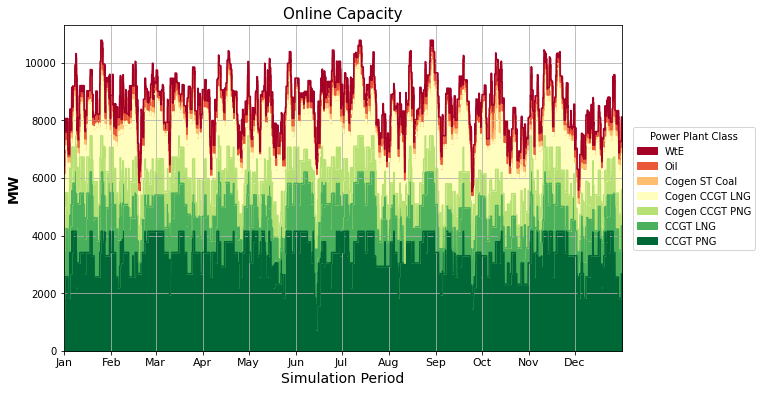

In [11]:
#Figure 13 Online capacities (baseline) (page 46)
plot_OnlineCapacity(Results, ppclasses='default') #ppclasses='default','total'

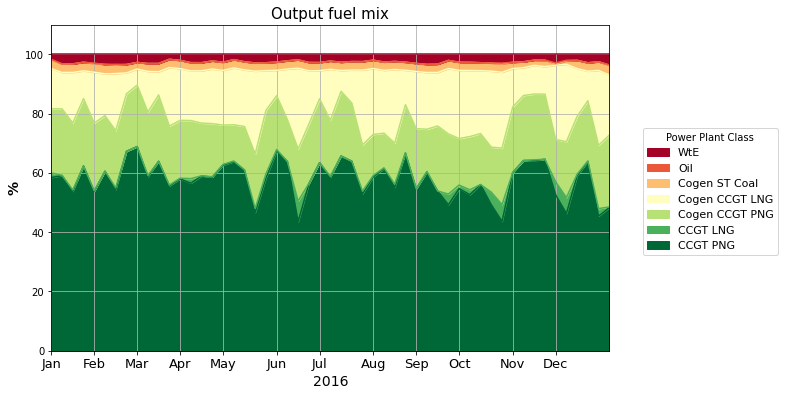

In [12]:
plot_fuelmix(Results,)

In [13]:
calc_allheat(Results)
compiled_prms = thermal_analysis(GenFleet, dParameters)

# new calc_heatstreams1 used
calc_heatstreams1(GenFleet, Results, by='outlet',)
calc_heatstreams1(GenFleet, Results, by='kind', latentheatfactors=dParameters['latent heat factors'])

C:\Users\tepang\Desktop\Test3\PowerPlants.py:1258: UserWarning: Calculated stack heat is too small to have sufficient sensible heat. Increasing the overall efficiency of the steam cycle.
  warnings.warn('Calculated stack heat is too small to have sufficient sensible heat. Increasing the overall '
C:\Users\tepang\Desktop\Test3\PowerPlants.py:1508: UserWarning: Calculated stack heat is too small to have sufficient sensible heat. Adjusting the overall efficiency of the steam cycle.
  warnings.warn('Calculated stack heat is too small to have sufficient sensible heat. Adjusting the overall '
C:\Users\tepang\Desktop\Test3\PowerPlants.py:1742: UserWarning: Calculated stack heat is too small to have sufficient sensible heat. Adjusting the Rankine efficiency to achieve the minimal stack heat.
  warnings.warn('Calculated stack heat is too small to have sufficient sensible heat. Adjusting the Rankine '


In [14]:
# Prepare the WRF input files for a day
# unit options 'W/m^2' 'MW'

WRF_SH, WRF_LH, WRF_Sea, total_MWh = prep_WRF_inputs(
    scenario='Test WRF - 2016 Apr (3)', 
    GenFleet=GenFleet, 
    PPcells_only=False,   # Set to False if you want the full grid (sparse)
    With_height=True,
    unit='MW',
    day='2016 Apr 15', 
    write_to_disk = True
)

Files written to: C:\Users\tepang\Desktop\Test3\To WRF\Test WRF - 2016 Apr (3)
